<a href="https://colab.research.google.com/github/arezyhs/Interpolasi-Lagrange/blob/main/Lagrange_Interpolation__Laju%20Aliran%20Massa%20Pasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📊 Studi Kasus: Prediksi Laju Aliran Massa Pasir (g/s) dengan Interpolasi Lagrange

Dalam studi kasus ini, kita menerapkan **Interpolasi Lagrange** untuk memprediksi Laju Aliran Massa Pasir (g/s) berdasarkan Laju Erosi Pipa (mm/year). Metode ini memungkinkan kita memperkirakan nilai di antara titik-titik data yang sudah ada menggunakan interpolasi polinomial.

---

**Author:** arezyh.s


Tabel Hasil Prediksi dan Galat untuk Orde 1 berdasarkan Interpolasi Lagrange:
   Laju Aliran Massa Pasir (g/s)  Y Aktual  Y Prediksi Orde 1  Galat Orde 1
0                            224  0.019266           0.019266      0.000000
1                            400  0.074818           0.074818      0.000000
2                            597  0.136999           0.136999      0.000000
3                            650  0.165217           0.153728      0.011489
4                            789  0.239224           0.197601      0.041622

Evaluasi Error untuk Orde 1:
  Error Relatif (%)    : 4.87%
  Korelasi Pearson (R) : 0.9901
  R-Squared            : 0.9803
  MAPE (%)             : 4.87%
  Batas Error Lagrange : 0.014313
--------------------------------------------------

Tabel Hasil Prediksi dan Galat untuk Orde 2 berdasarkan Interpolasi Lagrange:
   Laju Aliran Massa Pasir (g/s)  Y Aktual  Y Prediksi Orde 2  Galat Orde 2
0                            224  0.019266           0.076190      0.

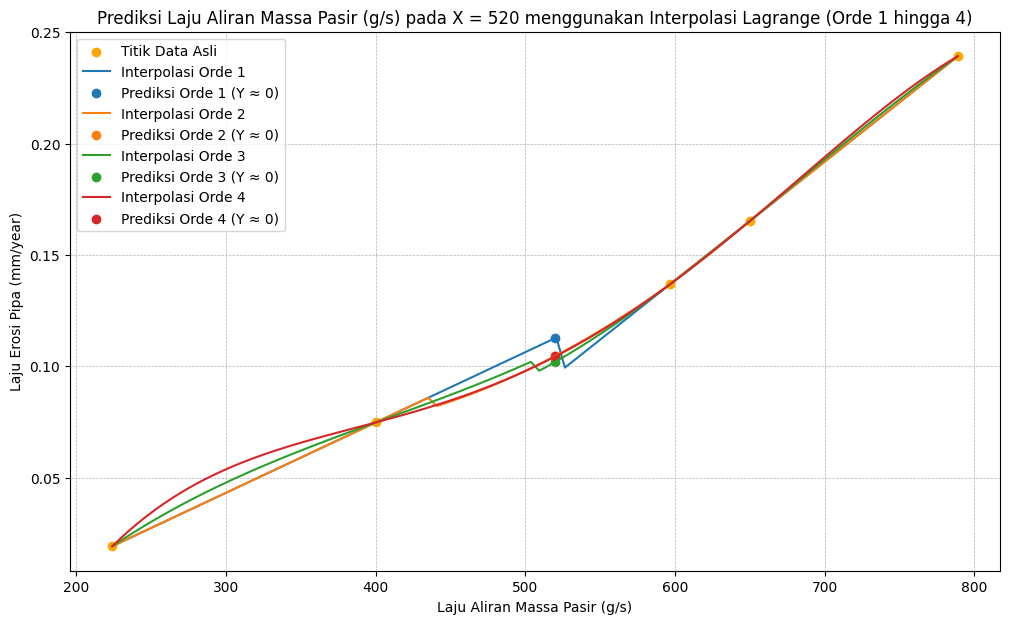

In [8]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import pandas as pd
import math
from decimal import Decimal, getcontext

# Set precision untuk Decimal dan pengaturan tampilan pandas
getcontext().prec = 6
pd.options.display.float_format = '{:.6f}'.format

# Data untuk Electricity (TWh) dan CO2 Emission (Metrics Ton per Capita)
electricity_data = np.array([224, 400, 597, 650, 789])
co2_emission_data = np.array([0.0192655, 0.074818, 0.1369988, 0.165217, 0.2392238])

# Membuat variabel simbolik untuk x
x = sp.symbols('x')

# Fungsi untuk membentuk polinomial Lagrange simbolik berdasarkan titik terdekat
def lagrange_polynomial(x_values, y_values):
    n = len(x_values)
    polynomial = 0
    for i in range(n):
        term = y_values[i]
        for j in range(n):
            if i != j:
                term *= (x - x_values[j]) / (x_values[i] - x_values[j])
        polynomial += term
    return sp.simplify(polynomial)

# Fungsi interpolasi polinomial Lagrange
def lagrange_interpolation(x_values, y_values, x_target, order):
    # Pilih titik-titik terdekat sejumlah order + 1
    idx = np.argsort(np.abs(x_values - x_target))[:order + 1]
    x_selected = x_values[idx]
    y_selected = y_values[idx]

    # Membentuk polinomial Lagrange untuk titik terpilih
    lagrange_poly = lagrange_polynomial(x_selected, y_selected)
    # Evaluasi polinomial Lagrange pada x_target
    interpolated_value = sp.lambdify(x, lagrange_poly, 'numpy')(x_target)
    return interpolated_value, lagrange_poly

# Fungsi untuk menghitung batas error Lagrange secara manual
def lagrange_error_bound_manual(x_values, y_values, x_target, order):
    # Pilih titik-titik terdekat sejumlah order + 2 untuk estimasi turunan berikutnya
    idx = np.argsort(np.abs(x_values - x_target))[:order + 2]
    x_selected = x_values[idx]
    y_selected = y_values[idx]

    # Hitung turunan ke-(order+1) menggunakan finite differences pada titik terdekat
    if order + 1 < len(x_selected):
        x0, x1, x2 = x_selected[:3]
        y0, y1, y2 = y_selected[:3]
        second_derivative = (y2 - 2 * y1 + y0) / ((x2 - x1) * (x1 - x0))
    else:
        second_derivative = 0

    # Evaluasi produk (x_target - x_i) untuk semua i pada x_selected
    product_term = Decimal(1)
    for xi in x_selected[:order + 1]:
        product_term *= Decimal(float(x_target - xi))  # Convert to float before Decimal

    # Hitung batas error
    error_estimate = abs(second_derivative * float(product_term) / math.factorial(order + 1))
    return error_estimate

# Fungsi untuk menghitung metrik error
def calculate_error_metrics(y_actual, y_pred):
    error_relatif = np.mean(np.abs(y_actual - y_pred) / y_actual) * 100
    R = np.corrcoef(y_actual, y_pred)[0, 1]
    R_squared = R ** 2
    MAPE = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    return error_relatif, R, R_squared, MAPE

# Menentukan hingga orde berapa interpolasi dilakukan
max_order = 4
if max_order >= len(electricity_data):
    max_order = len(electricity_data) - 1
    print(f"max_order terlalu besar, diatur menjadi {max_order} sesuai jumlah data.")

# Nilai x target untuk prediksi
x_target = 520

# Melakukan interpolasi Lagrange untuk x_target hingga max_order
higher_order_predictions = {}
lagrange_polynomials = {}
error_bounds = {}

# Menyimpan tabel hasil untuk tiap orde dalam dictionary
results_tables = {}

for order in range(1, max_order + 1):
    prediction, poly = lagrange_interpolation(electricity_data, co2_emission_data, x_target, order)
    higher_order_predictions[order] = prediction
    lagrange_polynomials[order] = poly
    error_bounds[order] = lagrange_error_bound_manual(electricity_data, co2_emission_data, x_target, order)

    # Hitung Y prediksi dan galat untuk setiap X dalam data
    y_pred = np.array([sp.lambdify(x, lagrange_polynomials[order], 'numpy')(xi) for xi in electricity_data])
    galat = np.abs(co2_emission_data - y_pred)

    # Membuat tabel per orde dengan format galat tanpa notasi ilmiah
    results_table = pd.DataFrame({
        "Laju Aliran Massa Pasir (g/s)": electricity_data,
        "Y Aktual": co2_emission_data,
        f"Y Prediksi Orde {order}": y_pred,
        f"Galat Orde {order}": galat
    }).round(6)
    results_tables[order] = results_table

    # Menampilkan tabel untuk setiap orde
    print(f"\nTabel Hasil Prediksi dan Galat untuk Orde {order} berdasarkan Interpolasi Lagrange:")
    print(results_table)

    # Menghitung metrik error untuk orde ini
    error_relatif, R, R_squared, MAPE = calculate_error_metrics(co2_emission_data, y_pred)

    print(f"\nEvaluasi Error untuk Orde {order}:")
    print(f"  Error Relatif (%)    : {error_relatif:.2f}%")
    print(f"  Korelasi Pearson (R) : {R:.4f}")
    print(f"  R-Squared            : {R_squared:.4f}")
    print(f"  MAPE (%)             : {MAPE:.2f}%")
    print(f"  Batas Error Lagrange : {error_bounds[order]:.6f}")
    print("-" * 50)

# Display hasil prediksi, persamaan polinomial, dan batas error Lagrange
print("\nHasil Prediksi dan Persamaan Polinomial Lagrange untuk X Prediksi dengan Berbagai Orde:")
for order in range(1, max_order + 1):
    print(f"\nOrde {order}:")
    print(f"  Prediksi untuk X = {x_target} adalah {higher_order_predictions[order]:.5f}")
    print(f"  Batas Error Lagrange (Manual): {error_bounds[order]:.5f}")
    print("  Persamaan Polinomial Lagrange:")
    sp.pprint(lagrange_polynomials[order])
    print("\n" + "-"*50)

# Plotting
plt.figure(figsize=(12, 7))
plt.scatter(electricity_data, co2_emission_data, color='orange', label='Titik Data Asli')
x_range = np.linspace(min(electricity_data), max(electricity_data), 100)

# Menghitung dan menampilkan nilai interpolasi untuk setiap orde hingga max_order
for order in range(1, max_order + 1):
    y_interp = [lagrange_interpolation(electricity_data, co2_emission_data, x, order)[0] for x in x_range]
    plt.plot(x_range, y_interp, label=f'Interpolasi Orde {order}')
    plt.scatter(x_target, higher_order_predictions[order], label=f'Prediksi Orde {order} (Y ≈ {higher_order_predictions[order]:.0f})')

plt.xlabel('Laju Aliran Massa Pasir (g/s)')
plt.ylabel('Laju Erosi Pipa (mm/year)')
plt.title(f'Prediksi Laju Aliran Massa Pasir (g/s) pada X = {x_target} menggunakan Interpolasi Lagrange (Orde 1 hingga {max_order})')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()